# Solver Performance Comparisons

This notebook demonstrates our testing and comparing the performance of different general purpose solvers.

### Imports and Setup

In [15]:
# Standard library
import logging
from pathlib import Path

# Third party
import matplotlib.pyplot as plt
import matplotlib_inline

import pandas as pd
import seaborn as sns 

# Local
import flexibleSubsetSelection as fss

# Initialize notebook settings
sns.set_theme() # set seaborn theme
matplotlib_inline.backend_inline.set_matplotlib_formats('svg') # vector plots
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
notebookName = "Fig4-performance"
dataDirectory = Path("..") / "data" / notebookName
figuresDirectory = Path("..") / "figures" / notebookName

fss.logger.setup(level = logging.WARNING) # set logging level for the package
file = "performanceData.csv"           # performance data file name
subsetSize = 10                        # size of subset selected
verbose = False                        # verbosity of solvers
seeds = [123, 231, 321, 132, 213]      # random generation seeds
numTrials = 5                          # number of trials per condition
algorithms = ["greedySwap", "bestOfRandom", "averageOfRandom"]

In [17]:
for datasetLength in range(100, 1100, 100):
    # Create dataset
    dataset = fss.Dataset(name="Experiment 1",
                          randTypes = "uniform", 
                          size = (datasetLength, 10), 
                          seed = seeds[0])

    # Preprocess dataset for objectives
    dataset.compute(mean=fss.metric.mean)
    dataset.compute(range=fss.metric.range)
    dataset.discretize(bins=6).encode()

    # Initialize coverage loss function
    coverageLoss = fss.UniCriterion(objective = fss.objective.discreteCoverage,
                                    solveArray = "encoded")

    # Initialize mean and range loss function
    objectives = [fss.objective.preserveMetric, fss.objective.preserveMetric]
    parameters = [{"metric": fss.metric.mean, "datasetMetric": dataset.mean},
                  {"metric": fss.metric.range, "datasetMetric": dataset.range}]
    weights = [1.0, 1.0]
    meanRangeLoss = fss.MultiCriterion(objectives, parameters, weights)

    # Initialize mean, range, and coverage loss function
    objectives = [fss.objective.preserveMetric, fss.objective.preserveMetric, 
                  fss.objective.discreteCoverage]
    parameters = [{"metric": fss.metric.mean, "datasetMetric": dataset.mean},
                  {"metric": fss.metric.range, "datasetMetric": dataset.range},
                  {"solveArray": "encoded"}]
    weights = [1.0, 1.0, 1.0]
    meanRangeCoverageLoss = fss.MultiCriterion(objectives, parameters, weights)

    lossFunctions = [coverageLoss, meanRangeLoss, meanRangeCoverageLoss]

    # Initialize solver
    solver = fss.Solver(algorithm = fss.algorithm.greedySwap, 
                        lossFunction = lossFunctions[0], 
                        savePath = dataDirectory / file)

    for i in range(numTrials):
        for j, lossFunction in enumerate(lossFunctions):
            for k, algorithm in enumerate(algorithms):
                solver.lossFunction = lossFunction
                solver.algorithm = getattr(fss.algorithm, algorithm)
                subset = solver.solve(dataset, subsetSize=subsetSize)

Text(0, 0.5, 'Computation Time (s)')

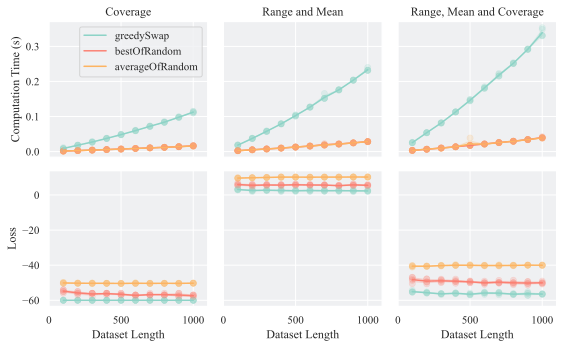

In [18]:
# Initialize color and plot settings
color = fss.Color()
fss.plot.initialize(color)

# Create figure
fig, axs = plt.subplots(nrows=2, 
                        ncols=3, 
                        figsize=(8, 5), 
                        sharey="row", 
                        sharex=True)

# Define your list of objectives
titles = ["Coverage", "Range and Mean", "Range, Mean and Coverage"]
palette = color.getPalette(algorithms, ["green", "orange", "yellow"])

df = pd.read_csv(os.path.join(dataDirectory, file))

for i, objective in enumerate(df['Loss Function'].unique()):
    for j, metric in enumerate(["Computation Time", "Loss"]):
        data = df[(df["Loss Function"] == objective) & 
                  (df["Subset Length"] == 10) & 
                  (df["Dataset Width"] == 10)]
                  
        sns.scatterplot(x="Dataset Length", 
                        y=metric, 
                        alpha=0.2,
                        hue="Algorithm", 
                        palette=palette, 
                        data=data,
                        ax=axs[j, i], 
                        s=40, 
                        edgecolor=None)
        
        sns.lineplot(x="Dataset Length", 
                     y=metric,
                     hue="Algorithm", 
                     palette=palette, 
                     data=data,
                     ax=axs[j, i])
        
        axs[j, i].set_xlim([0, 1100])
        axs[j, i].legend([]).set_visible(False)
    
    axs[0, i].set_title(titles[i], fontsize=12)

# Adjust legend for the first subplot
handles, labels = axs[0, 0].get_legend_handles_labels()
axs[0, 0].legend(handles[len(algorithms):], labels[len(algorithms):])

axs[1, 0].set_ylabel("Loss")
axs[0, 0].set_ylabel("Computation Time (s)")

In [23]:
# Create dataset
dataset = fss.Dataset(name="Experiment 2",
                      randTypes = "uniform", 
                      size = (500, 10), 
                      seed = seeds[0])

# Preprocess dataset for objectives
dataset.compute(mean=fss.metric.mean)
dataset.compute(range=fss.metric.range)
dataset.discretize(bins=6).encode()

# Initialize coverage loss function
coverageLoss = fss.UniCriterion(objective = fss.objective.discreteCoverage,
                                solveArray = "encoded")

# Initialize mean and range loss function
objectives = [fss.objective.preserveMetric, fss.objective.preserveMetric]
parameters = [{"metric": fss.metric.mean, "datasetMetric": dataset.mean},
                {"metric": fss.metric.range, "datasetMetric": dataset.range}]
weights = [1.0, 1.0]
meanRangeLoss = fss.MultiCriterion(objectives, parameters, weights)

# Initialize mean, range, and coverage loss function
objectives = [fss.objective.preserveMetric, fss.objective.preserveMetric, 
                fss.objective.discreteCoverage]
parameters = [{"metric": fss.metric.mean, "datasetMetric": dataset.mean},
                {"metric": fss.metric.range, "datasetMetric": dataset.range},
                {"solveArray": "encoded"}]
weights = [1.0, 1.0, 1.0]
meanRangeCoverageLoss = fss.MultiCriterion(objectives, parameters, weights)

lossFunctions = [coverageLoss, meanRangeLoss, meanRangeCoverageLoss]

# Initialize solver
solver = fss.Solver(algorithm = fss.algorithm.greedySwap, 
                    lossFunction = lossFunctions[0], 
                    savePath = os.path.join(dataDirectory, file))

for subsetSize in range(10, 500, 100):
    for i in range(numTrials):
        for j, lossFunction in enumerate(lossFunctions):
            for k, algorithm in enumerate(algorithms):
                print(i, j, k)
                solver.lossFunction = lossFunction
                solver.algorithm = getattr(fss.algorithm, algorithm)
                subset = solver.solve(dataset, subsetSize=subsetSize)

0 0 0
0 0 1
0 0 2
0 1 0
0 1 1
0 1 2
0 2 0
0 2 1
0 2 2
1 0 0
1 0 1
1 0 2
1 1 0
1 1 1
1 1 2
1 2 0
1 2 1
1 2 2
2 0 0
2 0 1
2 0 2
2 1 0
2 1 1
2 1 2
2 2 0
2 2 1
2 2 2
3 0 0
3 0 1
3 0 2
3 1 0
3 1 1
3 1 2
3 2 0
3 2 1
3 2 2
4 0 0
4 0 1
4 0 2
4 1 0
4 1 1
4 1 2
4 2 0
4 2 1
4 2 2
0 0 0
0 0 1
0 0 2
0 1 0
0 1 1
0 1 2
0 2 0
0 2 1
0 2 2
1 0 0
1 0 1
1 0 2
1 1 0
1 1 1
1 1 2
1 2 0
1 2 1
1 2 2
2 0 0
2 0 1
2 0 2
2 1 0
2 1 1
2 1 2
2 2 0
2 2 1
2 2 2
3 0 0
3 0 1
3 0 2
3 1 0
3 1 1
3 1 2
3 2 0
3 2 1
3 2 2
4 0 0
4 0 1
4 0 2
4 1 0
4 1 1
4 1 2
4 2 0
4 2 1
4 2 2
0 0 0
0 0 1
0 0 2
0 1 0
0 1 1
0 1 2
0 2 0
0 2 1
0 2 2
1 0 0
1 0 1
1 0 2
1 1 0
1 1 1
1 1 2
1 2 0
1 2 1
1 2 2
2 0 0
2 0 1
2 0 2
2 1 0
2 1 1
2 1 2
2 2 0
2 2 1
2 2 2
3 0 0
3 0 1
3 0 2
3 1 0
3 1 1
3 1 2
3 2 0
3 2 1
3 2 2
4 0 0
4 0 1
4 0 2
4 1 0
4 1 1
4 1 2
4 2 0
4 2 1
4 2 2
0 0 0
0 0 1
0 0 2
0 1 0
0 1 1
0 1 2
0 2 0
0 2 1
0 2 2
1 0 0
1 0 1
1 0 2
1 1 0
1 1 1
1 1 2
1 2 0
1 2 1
1 2 2
2 0 0
2 0 1
2 0 2
2 1 0
2 1 1
2 1 2
2 2 0
2 2 1
2 2 2
3 0 0
3 0 1
3 0 2
3 1 0
3 1 

Text(0, 0.5, 'Computation Time (s)')

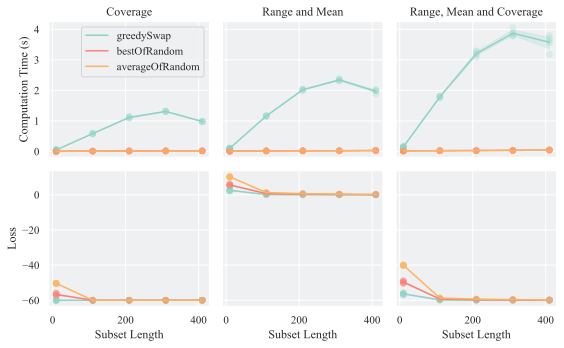

In [26]:
# Initialize color and plot settings
color = fss.plot.Color()
fss.plot.initialize(color)

# Create figure
fig, axs = plt.subplots(nrows=2, 
                        ncols=3, 
                        figsize=(8, 5), 
                        sharey="row", 
                        sharex=True)

# Define your list of objectives
titles = ["Coverage", "Range and Mean", "Range, Mean and Coverage"]
palette = color.getPalette(algorithms, ["green", "orange", "yellow"])

df = pd.read_csv(os.path.join(dataDirectory, file))

for i, objective in enumerate(df['Loss Function'].unique()):
    for j, metric in enumerate(["Computation Time", "Loss"]):
        data = df[(df["Loss Function"] == objective) & 
                  (df["Dataset Length"] == 500) & 
                  (df["Dataset Width"] == 10)]
                  
        sns.scatterplot(x="Subset Length", 
                        y=metric, 
                        alpha=0.2,
                        hue="Algorithm", 
                        palette=palette, 
                        data=data,
                        ax=axs[j, i], 
                        s=40, 
                        edgecolor=None)
        
        sns.lineplot(x="Subset Length", 
                     y=metric,
                     hue="Algorithm", 
                     palette=palette, 
                     data=data,
                     ax=axs[j, i])
        
        # axs[j, i].set_xlim([0, 1100])
        axs[j, i].legend([]).set_visible(False)
    
    axs[0, i].set_title(titles[i], fontsize=12)

# Adjust legend for the first subplot
handles, labels = axs[0, 0].get_legend_handles_labels()
axs[0, 0].legend(handles[len(algorithms):], labels[len(algorithms):])

axs[1, 0].set_ylabel("Loss")
axs[0, 0].set_ylabel("Computation Time (s)")

In [30]:
for datasetWidth in range(2, 20, 2):
    # Create dataset
    dataset = fss.Dataset(name="Expermeint 3", 
                          randTypes = "uniform", 
                          size = (1000, datasetWidth), 
                          seed = seeds[0])

    # Preprocess dataset for objectives
    dataset.compute(mean=fss.metric.mean)
    dataset.compute(range=fss.metric.range)
    dataset.discretize(bins=6).encode()

    # Initialize coverage loss function
    coverageLoss = fss.UniCriterion(objective = fss.objective.discreteCoverage,
                                    solveArray = "encoded")

    # Initialize mean and range loss function
    objectives = [fss.objective.preserveMetric, fss.objective.preserveMetric]
    parameters = [{"metric": fss.metric.mean, "datasetMetric": dataset.mean},
                  {"metric": fss.metric.range, "datasetMetric": dataset.range}]
    weights = [1.0, 1.0]
    meanRangeLoss = fss.MultiCriterion(objectives, parameters, weights)

    # Initialize mean, range, and coverage loss function
    objectives = [fss.objective.preserveMetric, fss.objective.preserveMetric, 
                  fss.objective.discreteCoverage]
    parameters = [{"metric": fss.metric.mean, "datasetMetric": dataset.mean},
                  {"metric": fss.metric.range, "datasetMetric": dataset.range},
                  {"solveArray": "encoded"}]
    weights = [1.0, 1.0, 1.0]
    meanRangeCoverageLoss = fss.MultiCriterion(objectives, parameters, weights)

    lossFunctions = [coverageLoss, meanRangeLoss, meanRangeCoverageLoss]

    # Initialize solver
    solver = fss.Solver(algorithm = fss.algorithm.greedySwap, 
                        lossFunction = lossFunctions[0], 
                        savePath = os.path.join(dataDirectory, file))

    for i in range(numTrials):
        for j, lossFunction in enumerate(lossFunctions):
            for k, algorithm in enumerate(algorithms):
                solver.lossFunction = lossFunction
                solver.algorithm = getattr(fss.algorithm, algorithm)
                subset = solver.solve(dataset, subsetSize=10)

Text(0, 0.5, 'Computation Time (s)')

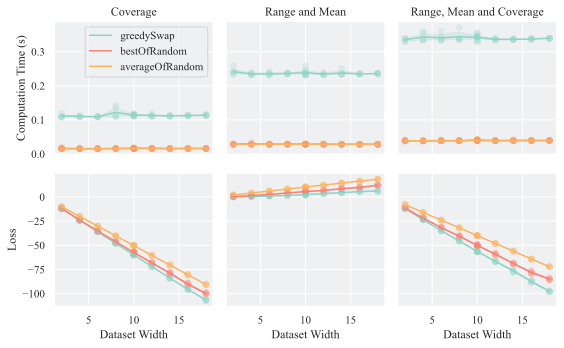

In [31]:
# Initialize color and plot settings
color = fss.plot.Color()
fss.plot.initialize(color)

# Create figure
fig, axs = plt.subplots(nrows=2, 
                        ncols=3, 
                        figsize=(8, 5), 
                        sharey="row", 
                        sharex=True)

# Define your list of objectives
titles = ["Coverage", "Range and Mean", "Range, Mean and Coverage"]
palette = color.getPalette(algorithms, ["green", "orange", "yellow"])

df = pd.read_csv(os.path.join(dataDirectory, file))

for i, objective in enumerate(df['Loss Function'].unique()):
    for j, metric in enumerate(["Computation Time", "Loss"]):
        data = df[(df["Loss Function"] == objective) & 
                  (df["Dataset Length"] == 1000) & 
                  (df["Subset Length"] == 10)]

        sns.scatterplot(x="Dataset Width", 
                        y=metric, 
                        alpha=0.2,
                        hue="Algorithm", 
                        palette=palette, 
                        data=data,
                        ax=axs[j, i], 
                        s=40, 
                        edgecolor=None)
        
        sns.lineplot(x="Dataset Width", 
                     y=metric,
                     hue="Algorithm", 
                     palette=palette, 
                     data=data,
                     ax=axs[j, i])
        
        # axs[j, i].set_xlim([0, 1100])
        axs[j, i].legend([]).set_visible(False)
    
    axs[0, i].set_title(titles[i], fontsize=12)

# Adjust legend for the first subplot
handles, labels = axs[0, 0].get_legend_handles_labels()
axs[0, 0].legend(handles[len(algorithms):], labels[len(algorithms):])

axs[1, 0].set_ylabel("Loss")
axs[0, 0].set_ylabel("Computation Time (s)")